<a href="https://colab.research.google.com/github/ZeyuSun/thor/blob/main/pathway_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install/Upgrade packages
!pip install venn
!pip install networkx

In [ ]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
plt.rcParams['image.cmap']='coolwarm'
import networkx as nx

In [ ]:
# Modifying venn function
from functools import partial
from venn import draw_venn
from matplotlib.colors import to_rgba
from matplotlib.cm import ScalarMappable

def generate_logics(n_sets):
    """Generate intersection identifiers in binary (0010 etc)"""
    for i in range(1, 2**n_sets):
        yield bin(i)[2:].zfill(n_sets)

def is_valid_dataset_dict(data):
    """Validate passed data (must be dictionary of sets)"""
    if not (hasattr(data, "keys") and hasattr(data, "values")):
        return False
    for dataset in data.values():
        if not isinstance(dataset, set):
            return False
    else:
        return True

def generate_colors(cmap="viridis", n_colors=6, alpha=.4):
    """Generate colors from matplotlib colormap; pass list to use exact colors"""
    if not isinstance(n_colors, int) or (n_colors < 2) or (n_colors > 6):
        raise ValueError("n_colors must be an integer between 2 and 6")
    if isinstance(cmap, list):
        colors = [to_rgba(color, alpha=alpha) for color in cmap]
    else:
        scalar_mappable = ScalarMappable(cmap=cmap)
        colors = scalar_mappable.to_rgba(range(n_colors), alpha=alpha).tolist()
    return colors[:n_colors]

def generate_petal_labels(datasets, fmt="{size}"):
    """Generate petal descriptions for venn diagram based on set sizes"""
    datasets = list(datasets)
    n_sets = len(datasets)
    dataset_union = set.union(*datasets)
    universe_size = len(dataset_union)
    petal_labels = {}
    for logic in generate_logics(n_sets):
        included_sets = [
            datasets[i] for i in range(n_sets) if logic[i] == "1"
        ]
        excluded_sets = [
            datasets[i] for i in range(n_sets) if logic[i] == "0"
        ]
        petal_set = (
            (dataset_union & set.intersection(*included_sets)) -
            set.union(set(), *excluded_sets)
        )
        # Modified! Added enum
        petal_labels[logic] = fmt.format(
            logic=logic, size=len(petal_set),
            percentage=(100*len(petal_set)/universe_size),
            enum=','.join([str(i) for i in petal_set])
        )
    return petal_labels

def venn_dispatch(data, func, fmt="{size}", hint_hidden=False, cmap="viridis", alpha=.4, figsize=(8, 8), fontsize=13, legend_loc="upper right", ax=None):
    """Check input, generate petal labels, draw venn or pseudovenn diagram"""
    if not is_valid_dataset_dict(data):
        raise TypeError("Only dictionaries of sets are understood")
    if hint_hidden and (func == draw_pseudovenn6) and (fmt != "{size}"):
        error_message = "To use fmt='{}', set hint_hidden=False".format(fmt)
        raise NotImplementedError(error_message)
    n_sets = len(data)
    return func(
        petal_labels=generate_petal_labels(data.values(), fmt),
        dataset_labels=data.keys(), hint_hidden=hint_hidden,
        colors=generate_colors(n_colors=n_sets, cmap=cmap, alpha=alpha),
        figsize=figsize, fontsize=fontsize, legend_loc=legend_loc, ax=ax
    )
venn = partial(venn_dispatch, func=draw_venn, hint_hidden=False)

## Download and read data

In [ ]:
!gdown --id 1_BVRFD8qxMSStHkYba4xrJUaLNOC5Aq3
!gdown --id 1Xt97A0LRhuAoum0rpHHbEGC2oRHa-jJh
!gdown --id 1S1vrLessTvWeA-TOBQaqs2osb5tYVT_6
!gdown --id 1lWi8Eqrx-DwLBZzyu6od0l8g-4qLJqvw
!gdown --id 1LWO5nfUbRIZ5Ak9twU9SjqtQXrn3tCHk
!gdown --id 1n4pnqgmj0cEDcxvYG6eZ-nPtjPp3Qoks

Downloading...
From: https://drive.google.com/uc?id=1_BVRFD8qxMSStHkYba4xrJUaLNOC5Aq3
To: /content/Pathways_B.csv
100% 203k/203k [00:00<00:00, 73.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xt97A0LRhuAoum0rpHHbEGC2oRHa-jJh
To: /content/Pathways_F.csv
100% 154k/154k [00:00<00:00, 56.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1S1vrLessTvWeA-TOBQaqs2osb5tYVT_6
To: /content/Pathways_K.csv
100% 207k/207k [00:00<00:00, 78.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lWi8Eqrx-DwLBZzyu6od0l8g-4qLJqvw
To: /content/RNASeq_B.csv
100% 1.52M/1.52M [00:00<00:00, 47.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LWO5nfUbRIZ5Ak9twU9SjqtQXrn3tCHk
To: /content/RNASeq_F.csv
100% 317k/317k [00:00<00:00, 95.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n4pnqgmj0cEDcxvYG6eZ-nPtjPp3Qoks
To: /content/RNASeq_K.csv
100% 1.65M/1.65M [00:00<00:00, 106MB/s]


In [ ]:
# Constants
SPECIES = ['B', 'F', 'K']
COMMUNITIES = ['B', 'F', 'K', 'BF', 'FK', 'BK', 'BFK']

pathways = {}
rnaseq = {}
for s in SPECIES:
    pathways_file = 'Pathways_{}.csv'.format(s)
    df = pd.read_csv(pathways_file, index_col='geneID').dropna()
    df = df[~df.index.duplicated(keep='first')]
    pathways[s] = df
for s in SPECIES:
    rnaseq_file = 'RNASeq_{}.csv'.format(s)
    rnaseq[s] = pd.read_csv(rnaseq_file, index_col=0).dropna()
    rnaseq[s]

Take a peek at what we got:

In [ ]:
pathways['K'].head()

,DescC
geneID,
BOW65_RS00010,Transporters [BR:ko02000]
BOW65_RS00015,Two-component system [PATH:ko02020]
BOW65_RS00025,Two-component system [PATH:ko02020]
BOW65_RS00075,Transporters [BR:ko02000]
BOW65_RS00080,ABC transporters [PATH:ko02010]


In [ ]:
rnaseq['K'].head()

,K1,K2,K3,K4,BK1,BK2,BK3,BK4,FK1,FK2,FK3,FK4,BFK1,BFK2,BFK3,BFK4
Pseudomonas geneID,,,,,,,,,,,,,,,,
BOW65_RS00005,9.458374,11.774823,8.540946,12.400590,14.677134,7.932638,11.908059,14.928793,12.071304,10.228006,14.793221,12.572868,14.289372,14.634418,12.905729,14.196224
BOW65_RS00010,19.242900,15.573153,18.938620,13.130037,21.749285,22.951172,22.733567,15.071880,20.131819,14.361241,23.730792,16.596186,19.591083,21.474418,19.100478,18.204570
BOW65_RS00015,1.630754,1.139499,1.485382,1.094170,1.986015,4.545669,2.165102,0.953916,1.985924,0.840658,1.496933,1.860784,1.666252,1.643721,2.452088,1.169101
BOW65_RS00020,2.609207,0.379833,1.856727,1.094170,2.421969,3.119577,1.598051,1.573962,2.141683,1.401097,2.597619,2.464282,1.565267,1.590698,1.806802,1.224772
BOW65_RS00025,149.377085,95.338082,137.397834,121.817562,78.617125,96.261227,63.354996,76.074840,150.969176,78.671581,112.534147,120.950990,92.653703,58.060462,85.995172,83.896900


## Processing pathways

In [ ]:
def run_analysis(species, replicates,
                 kmin=30, par_corr=False, thresh = 0.05):
    
    """Pathway correlation analysis using the RNA-Seq data of a species.

    Args:
        species (str): The species of the RNAseq data. Can be 'B', 'F', or 'K'.
        replicates (list of str): List of names of replicated experiments.
            E.g., ['BF1', 'BF2', 'BF3', 'BF4'].
        kmin (int): The smallest number of genes needed in a pathway for it to
            be selected.
        par_corr (bool): If true, cluster pathways using partial correlation.
            Otherwise, use correlation. Default to False.
    """
    # Process dataframe
    community = replicates[0][:-1]
    df = pd.concat([pathways[species], rnaseq[species]], axis=1, join='inner')
    df['std'] = df[replicates].std(axis=1)
    df = df[df['std'] > 0]  # drop rows with zero std
    #print(df)

    # Construct pathway data matrix
    lengths = df.groupby('DescC').size()
    top_pathways = lengths[lengths >= kmin].index.sort_values()

    X = np.zeros((len(top_pathways), kmin*len(replicates)))  # pathway data matrix
    for p, pathway in enumerate(top_pathways):
        x = df.loc[df['DescC'] == pathway, replicates].iloc[:kmin].to_numpy()
        X[p] = x.flatten()

    if False:
        plt.figure(figsize=(15,6))
        plt.imshow(X, aspect='auto')
        plt.colorbar()
        plt.title(r'{} in {}: RNASeq $\times$ Pathway with kmin={}'.format(
            species, community, kmin))
        plt.yticks(range(len(top_pathways)), top_pathways.values)
        plt.xlabel('Gene (aggregated)')
        plt.tight_layout()
        plt.show()
    
    # Correlation matrix / partial correlation matrix
    R_list, Pval_list = [], []
    for i, _ in enumerate(replicates):
        X_df = pd.DataFrame(X[:,i*kmin:(i+1)*kmin].T, columns=top_pathways)
        R_type = "Partial correlation" if par_corr else "Correlation"
        R_list.append(X_df.corr().to_numpy())  # correlation matrix
        Pval_list.append(X_df.corr(method=lambda x, y: pearsonr(x, y)[1]).to_numpy())
        if par_corr:
            raise NotImplementedError
    R = sum(R_list) / len(R_list)
    Pval = sum(Pval_list) / len(Pval_list)

    if False:
        plt.figure(figsize=(10,5))
        plt.subplot(121); plt.imshow(R); plt.colorbar(); plt.title(R_type);
        plt.subplot(122); plt.imshow(Pval); plt.colorbar(); plt.title("Pval");
        plt.suptitle('{} in {}'.format(species, community))
        plt.show()
    
    # Thresholding
    A = R.copy()  # Weighted adjacency matrix
    A[Pval > thresh] = 0
    if False:
        plt.figure(figsize=(5,5))
        plt.imshow(A); plt.colorbar();
        plt.title('{} in {}: weighted adjacency matrix'.format(species, community))
        plt.show()
    
    # Construct graph
    conn = (Pval.min(0) <= thresh)
    Ac = A[conn][:,conn]  # Adjacency mat of connected subgraph(s)
    Ac = (Ac + Ac.T) / 2
    G = nx.from_numpy_array(Ac)  # Graph
    conn_pathways = top_pathways[conn]
    degrees = pd.Series([-1] * len(top_pathways), index=top_pathways)
    degrees[conn_pathways] = [deg for _, deg in G.degree]
    nx.set_node_attributes(G, {n: conn_pathways[n] for n in G}, name="name")
    if True:
        title = ('{} graph for {} in {} community:\n' +
                'kmin={}, #pathways={}, p-val<{}, #nodes={}, min/max \u03C1={:.2f}/{:.2f}').format(
                R_type, species, community,
                kmin, len(conn_pathways), thresh, Ac.shape[0], Ac.min(), Ac.max())
        plt.figure()
        nx_plot_graph(G)
        plt.tight_layout()
        plt.title(title)
        plt.show()

    return degrees

In [ ]:
def nx_plot_graph(G, label_aside=False):
    weights = np.array([e[-1] for e in G.edges.data('weight')])
    wmax = np.absolute(weights).max()
    pos = nx.spring_layout(G)
    #pos = nx.kamada_kawai_layout(G)
    import matplotlib
    cmap = matplotlib.cm.get_cmap('RdBu') #'coolwarm')
    nx.draw(G, pos,
            node_size=100,
            #linewidths=10,
            node_color='C1',
            alpha=0.9,
            with_labels=False,
            width=8*weights,
            edge_cmap=cmap,
            edge_vmin=-wmax,
            edge_vmax=wmax,
            edge_color=weights)

    pos_labels = {k: (v[0]+0.05, v[1]) for k, v in pos.items()}
    labels = nx.get_node_attributes(G, 'name')
    nx.draw_networkx_labels(G, pos_labels, labels, font_size=8, horizontalalignment='left')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


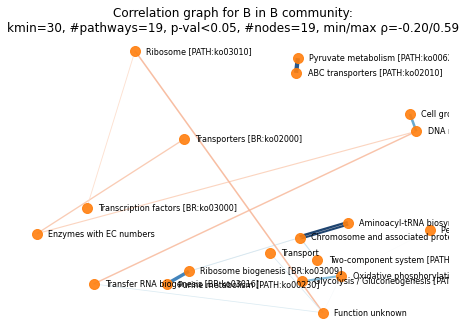

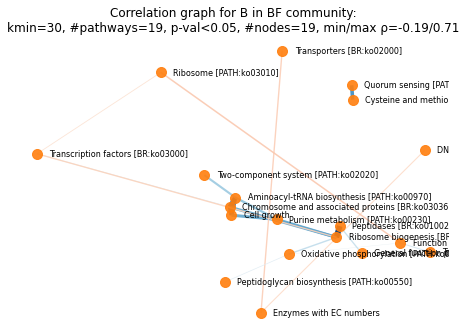

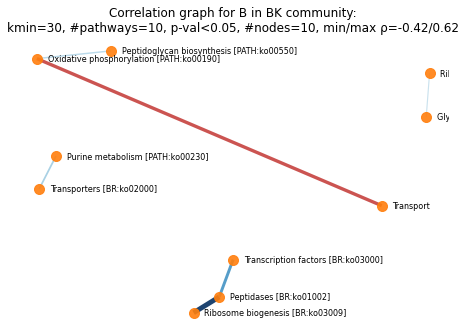

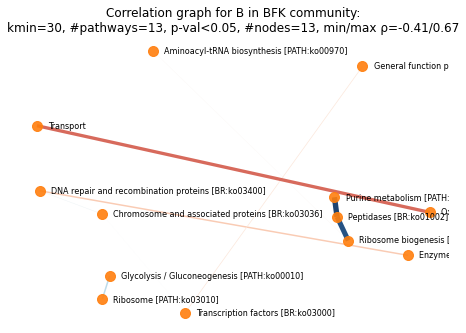

                                                    B  BF  BK  BFK
DescC                                                             
ABC transporters [PATH:ko02010]                     1  -1  -1   -1
Aminoacyl-tRNA biosynthesis [PATH:ko00970]          2   4  -1    1
Cell growth                                         1   3  -1   -1
Chromosome and associated proteins [BR:ko03036]     3   4  -1    2
Cysteine and methionine metabolism [PATH:ko00270]  -1   1  -1   -1
DNA repair and recombination proteins [BR:ko03400]  3   1  -1    2
Enzymes with EC numbers                             2   2  -1    1
Function unknown                                    4   3  -1   -1
General function prediction only                   -1   1  -1    1
Glycolysis / Gluconeogenesis [PATH:ko00010]         1  -1   1    1
Oxidative phosphorylation [PATH:ko00190]            3   3   2    1
Peptidases [BR:ko01002]                            -1   2   2    2
Peptidoglycan biosynthesis [PATH:ko00550]           1   1   1 

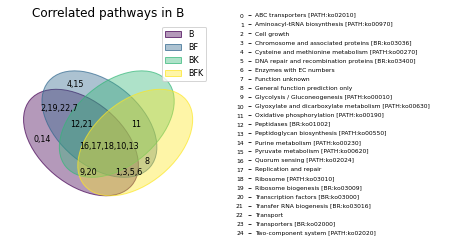

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


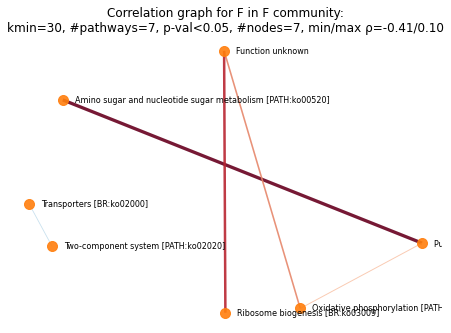

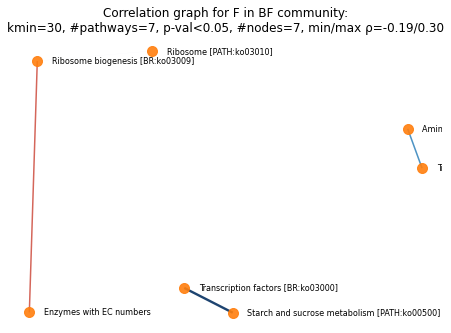

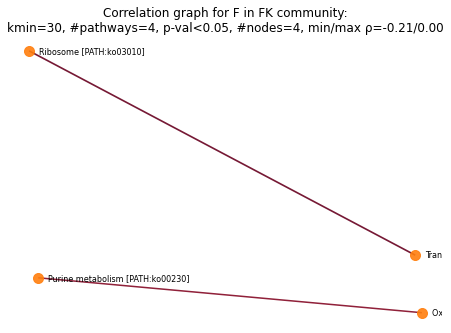

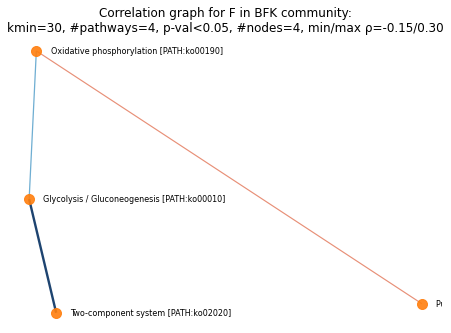

                                                    F  BF  FK  BFK
DescC                                                             
Amino sugar and nucleotide sugar metabolism [PA...  1   1  -1   -1
Enzymes with EC numbers                            -1   1  -1   -1
Fatty acid biosynthesis [PATH:ko00061]             -1  -1  -1   -1
Function unknown                                    2  -1  -1   -1
General function prediction only                   -1  -1  -1   -1
Glycolysis / Gluconeogenesis [PATH:ko00010]        -1  -1  -1    2
Oxidative phosphorylation [PATH:ko00190]            2  -1   1    2
Peptidases [BR:ko01002]                            -1  -1  -1   -1
Purine metabolism [PATH:ko00230]                    2  -1   1    1
Ribosome [PATH:ko03010]                            -1   1   1   -1
Ribosome biogenesis [BR:ko03009]                    1   2  -1   -1
Starch and sucrose metabolism [PATH:ko00500]       -1   1  -1   -1
Transcription factors [BR:ko03000]                 -1   1  -1 

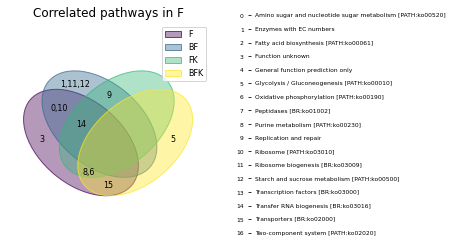

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


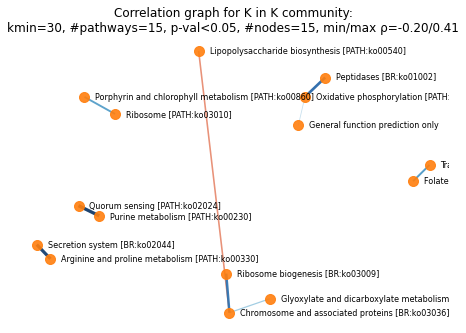

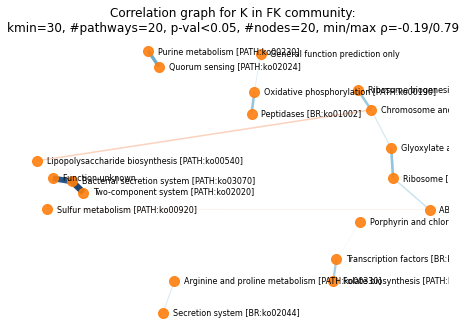

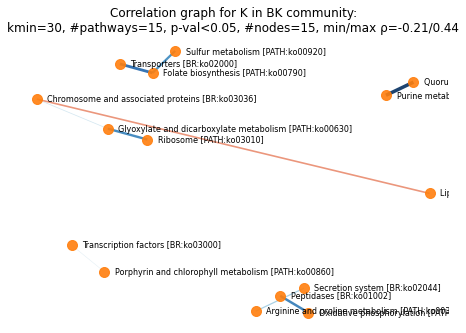

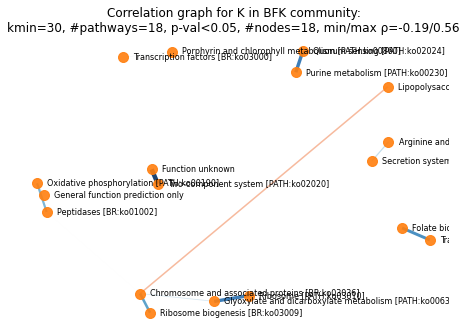

                                                    K  FK  BK  BFK
DescC                                                             
ABC transporters [PATH:ko02010]                    -1   2  -1   -1
Arginine and proline metabolism [PATH:ko00330]      1   1   1    1
Bacterial secretion system [PATH:ko03070]          -1   2  -1   -1
Chaperones and folding catalysts [BR:ko03110]      -1  -1  -1   -1
Chromosome and associated proteins [BR:ko03036]     3   3   2    4
Enzymes with EC numbers                            -1  -1  -1   -1
Folate biosynthesis [PATH:ko00790]                  1   1   2    1
Function unknown                                   -1   1  -1    1
General function prediction only                    1   1  -1    1
Glycine, serine and threonine metabolism [PATH:... -1  -1  -1   -1
Glycolysis / Gluconeogenesis [PATH:ko00010]        -1  -1  -1   -1
Glyoxylate and dicarboxylate metabolism [PATH:k...  1   2   2    2
Lipopolysaccharide biosynthesis [PATH:ko00540]      1   1   1 

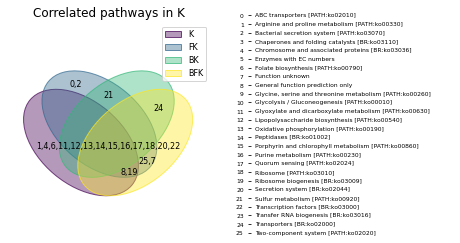

In [ ]:
kmin = 30 # minimum genes in a pathway
N = 4 # number of replicates

for sp in SPECIES:
    lengths = pathways[sp].groupby('DescC').size()
    top_pathways = lengths[lengths >= kmin].index.sort_values()
    degrees = pd.DataFrame()
    conn_pathways = {}  # A dict mapping comm to connected pathway IDs
    for comm in COMMUNITIES:
        if sp not in comm:
            continue
        reps = [comm + str(i) for i in range(1,1+N)]
        degrees[comm] = run_analysis(sp, reps, kmin=kmin)
        conn_pathways[comm] = set((degrees[comm] >= 0).to_numpy().nonzero()[0])

    if True:
        print(degrees)

    if True:
        fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].set_title('Correlated pathways in {}'.format(sp))
        venn(conn_pathways, fmt="{enum}", fontsize=8, ax=ax[0])
        ax[1].invert_yaxis()
        ax[1].set_yticks(range(len(top_pathways)))
        ax[1].tick_params(axis='y', which='major', labelsize=6)
        for spine in ax[1].spines.values():
            spine.set_visible(False)
        ax[1].set_xticks([])
        for i, pathway in enumerate(top_pathways):
            ax[1].text(0.02, i, pathway, fontdict={'size': 6}, verticalalignment='center')
        plt.show()

In [ ]:
* pathway node
* dummy correlation, tridiag, mean = pathway id
* thresh = 0.32. (K, 26 pathways, 120 samples)